In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from IPython.display import display, HTML
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Common function definitions
def graphRes(act, pred):
    ax = plt.gca()
    for pos in positions:
        ax.scatter(act[pos],pred[pos], label=f'{pos} ({r2_score(act[pos], pred[pos]).round(2)})')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(labels)
    ax.plot(act['QB'],act['QB'],color='black') # y==x reference line
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

def printStats(y_dev, y_pred):
    graphRes(y_dev, y_pred)

    stats = pd.DataFrame(index = [positions], columns = ['MAE','RMSE','R^2'])
    for pos in positions:
        stats.loc[pos,'MAE'] = mean_absolute_error(y_dev[pos], y_pred[pos]).round(1)
        stats.loc[pos,'RMSE'] = round(math.sqrt(mean_squared_error(y_dev[pos], y_pred[pos])),1)
        stats.loc[pos,'R^2'] = r2_score(y_dev[pos], y_pred[pos]).round(2)
    
    display(stats)
    
def cvGrid(params):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(grid.cv_results_)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [3]:
# Partition training, dev, and test data
positions = ['QB','RB','WR','TE']
X_train, X_dev, X_test = {}, {}, {}
y_train, y_dev, y_test = {}, {}, {}
for pos in positions:
    Xy = pd.read_csv(f'../{pos}.csv').dropna(subset=['fanPts'])
    X = Xy.loc[:,Xy.columns.str.contains('-\d+') | Xy.columns.str.match('fanPts')] \
        .drop('fanPts',axis=1) \
        .fillna(0)
    y = Xy.fanPts
    
    # Split
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.3, random_state=0)
    X_dev_raw, X_test_raw, y_dev_raw, y_test_raw = train_test_split(X_test_raw, y_test_raw, test_size=0.5, random_state=0)
    
    # Scale X data
    ss = preprocessing.StandardScaler()
    X_train[pos] = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
    X_dev[pos] = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
    X_test[pos] = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)
    
    # Leave y data in original units
    y_train[pos] = y_train_raw
    y_dev[pos] = y_dev_raw
    y_test[pos] = y_test_raw

### LASSO Regression

#### Base model

,pass_touchdown-2_seasonTotal,fanPts-1,touchdown-1_seasonTotal,sack-3_avgPerGame,air_yards-3_seasonTotal,sack-2_avgPerGame,pass_touchdown-1_seasonTotal,yards_gained-1_avgPerGame,tackled_for_loss-3_avgPerGame,fumble-3_avgPerGame,touchdown-3_avgPerGame,qb_scramble-2_avgPerGame,sack-1_avgPerGame,tackled_for_loss-2_seasonTotal,pass_touchdown-3_seasonTotal,qb_hit-3_seasonTotal,air_yards-1_seasonTotal,fumble-2_avgPerGame,pass_attempt-2_avgPerGame,qb_scramble-1_avgPerGame,pass_attempt-1_seasonTotal,qb_scramble-2_seasonTotal,sack-2_seasonTotal,tackled_for_loss-3_seasonTotal,fumble-3_seasonTotal,yards_gained-3_seasonTotal,qb_dropback-2_seasonTotal,touchdown-3_seasonTotal,complete_pass-3_seasonTotal,pass_attempt-3_seasonTotal,qb_hit-2_seasonTotal,complete_pass-2_seasonTotal,air_yards-2_seasonTotal,yards_gained-1_seasonTotal,pass_attempt-2_seasonTotal,complete_pass-1_seasonTotal,touchdown-2_seasonTotal,fumble-2_seasonTotal,sack-1_seasonTotal,qb_scramble-1_seasonTotal,qb_hit-1_seasonTotal,fumble-1_seasonTotal,qb_dropback-1_seasonTotal,yards_gained-2_seasonTotal,fanPts-3,qb_dropback-3_seasonTotal,qb_scramble-3_seasonTotal,qb_scramble-3_avgPerGame,qb_hit-3_avgPerGame,qb_dropback-3_avgPerGame,air_yards-3_avgPerGame,pass_touchdown-3_avgPerGame,pass_attempt-3_avgPerGame,complete_pass-3_avgPerGame,yards_gained-3_avgPerGame,qb_hit-2_avgPerGame,qb_dropback-2_avgPerGame,air_yards-2_avgPerGame,pass_touchdown-2_avgPerGame,complete_pass-2_avgPerGame,touchdown-2_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,qb_hit-1_avgPerGame,qb_dropback-1_avgPerGame,air_yards-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_attempt-1_avgPerGame,complete_pass-1_avgPerGame,touchdown-1_avgPerGame,fumble-1_avgPerGame,fanPts-2,tackled_for_loss-1_avgPerGame,sack-3_seasonTotal,tackled_for_loss-1_seasonTotal
1,27.727,25.419,20.292,-8.164,7.329,-6.698,6.205,5.017,-4.037,2.609,-2.271,-1.901,-1.691,-1.582,1.534,1.463,0.934,-0.877,-0.497,-0.063,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000


,yards_gained-1_seasonTotal,fanPts-1,fanPts-2,fanPts-3,fumble-1_avgPerGame,touchdown-2_seasonTotal,fumble-2_seasonTotal,yards_gained-3_seasonTotal,tackled_for_loss-3_seasonTotal,rush_touchdown-3_seasonTotal,rush_attempt-3_seasonTotal,tackled_for_loss-2_seasonTotal,yards_gained-2_seasonTotal,touchdown-3_seasonTotal,rush_touchdown-2_seasonTotal,rush_attempt-2_seasonTotal,touchdown-1_seasonTotal,fumble-1_seasonTotal,tackled_for_loss-1_seasonTotal,rush_touchdown-1_seasonTotal,fumble-3_seasonTotal,rush_touchdown-1_avgPerGame,rush_attempt-1_avgPerGame,touchdown-2_avgPerGame,touchdown-3_avgPerGame,fumble-3_avgPerGame,yards_gained-3_avgPerGame,tackled_for_loss-3_avgPerGame,rush_touchdown-3_avgPerGame,rush_attempt-3_avgPerGame,fumble-2_avgPerGame,tackled_for_loss-1_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,rush_touchdown-2_avgPerGame,rush_attempt-2_avgPerGame,touchdown-1_avgPerGame,yards_gained-1_avgPerGame,rush_attempt-1_seasonTotal
1,25.300,19.289,5.095,1.554,-0.786,0.610,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000


,fanPts-1,yards_gained-1_seasonTotal,pass_touchdown-2_seasonTotal,air_yards-3_avgPerGame,yards_gained-2_seasonTotal,yards_after_catch-2_seasonTotal,fumble-2_seasonTotal,tackled_for_loss-1_seasonTotal,tackled_for_loss-3_avgPerGame,fumble-1_avgPerGame,pass_attempt-1_seasonTotal,air_yards-2_seasonTotal,pass_attempt-3_seasonTotal,complete_pass-3_seasonTotal,touchdown-3_seasonTotal,fumble-3_seasonTotal,yards_gained-3_seasonTotal,tackled_for_loss-3_seasonTotal,fumble-1_seasonTotal,touchdown-1_seasonTotal,pass_touchdown-1_seasonTotal,pass_attempt-2_seasonTotal,complete_pass-2_seasonTotal,touchdown-2_seasonTotal,air_yards-3_seasonTotal,complete_pass-1_seasonTotal,tackled_for_loss-2_seasonTotal,yards_after_catch-1_seasonTotal,air_yards-1_seasonTotal,pass_touchdown-3_seasonTotal,fanPts-3,yards_after_catch-3_seasonTotal,tackled_for_loss-1_avgPerGame,yards_after_catch-3_avgPerGame,pass_touchdown-3_avgPerGame,pass_attempt-3_avgPerGame,complete_pass-3_avgPerGame,touchdown-3_avgPerGame,fumble-3_avgPerGame,yards_gained-3_avgPerGame,yards_after_catch-2_avgPerGame,air_yards-2_avgPerGame,pass_touchdown-2_avgPerGame,pass_attempt-2_avgPerGame,complete_pass-2_avgPerGame,touchdown-2_avgPerGame,fumble-2_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,yards_after_catch-1_avgPerGame,air_yards-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_attempt-1_avgPerGame,complete_pass-1_avgPerGame,touchdown-1_avgPerGame,fanPts-2,yards_gained-1_avgPerGame
1,19.448,18.534,4.656,-3.864,3.572,2.205,1.664,1.386,-0.268,-0.087,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000


,yards_gained-1_seasonTotal,fanPts-1,yards_gained-1_avgPerGame,yards_gained-2_seasonTotal,air_yards-1_avgPerGame,complete_pass-3_avgPerGame,touchdown-3_seasonTotal,pass_touchdown-3_seasonTotal,fumble-1_seasonTotal,fumble-2_avgPerGame,complete_pass-2_seasonTotal,tackled_for_loss-2_seasonTotal,pass_attempt-1_seasonTotal,yards_after_catch-2_seasonTotal,pass_attempt-3_seasonTotal,complete_pass-3_seasonTotal,fumble-3_seasonTotal,yards_gained-3_seasonTotal,tackled_for_loss-3_seasonTotal,touchdown-1_seasonTotal,pass_touchdown-2_seasonTotal,air_yards-2_seasonTotal,pass_touchdown-1_seasonTotal,pass_attempt-2_seasonTotal,air_yards-3_seasonTotal,fumble-2_seasonTotal,complete_pass-1_seasonTotal,yards_after_catch-1_seasonTotal,air_yards-1_seasonTotal,touchdown-2_seasonTotal,fanPts-3,yards_after_catch-3_seasonTotal,tackled_for_loss-1_avgPerGame,yards_after_catch-3_avgPerGame,air_yards-3_avgPerGame,pass_touchdown-3_avgPerGame,pass_attempt-3_avgPerGame,touchdown-3_avgPerGame,fumble-3_avgPerGame,yards_gained-3_avgPerGame,tackled_for_loss-3_avgPerGame,yards_after_catch-2_avgPerGame,air_yards-2_avgPerGame,pass_touchdown-2_avgPerGame,pass_attempt-2_avgPerGame,complete_pass-2_avgPerGame,touchdown-2_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,yards_after_catch-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_attempt-1_avgPerGame,complete_pass-1_avgPerGame,touchdown-1_avgPerGame,fumble-1_avgPerGame,fanPts-2,tackled_for_loss-1_seasonTotal
1,16.687,5.563,4.569,1.088,0.977,-0.969,0.932,0.802,-0.785,-0.650,0.101,-0.095,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000


,MAE,RMSE,R^2
QB,61.600,81.800,0.430
RB,44.200,61.600,0.430
WR,37.800,55.000,0.430
TE,20.900,29.500,0.500


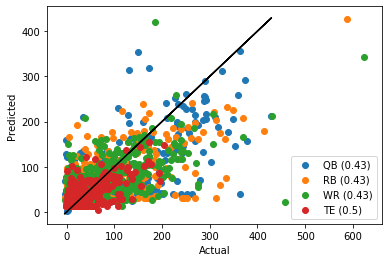

In [4]:
y_pred = {}
for pos in positions:
    m = linear_model.Lasso()
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    coefs = pd.DataFrame([X_train[pos].columns,m.coef_]).transpose()
    display(coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose())
    
printStats(y_dev, y_pred)

#### GridSearchCV

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


,pass_touchdown-2_seasonTotal,fanPts-1,touchdown-1_seasonTotal,sack-3_avgPerGame,air_yards-3_seasonTotal,sack-2_avgPerGame,pass_touchdown-1_seasonTotal,yards_gained-1_avgPerGame,tackled_for_loss-3_avgPerGame,fumble-3_avgPerGame,touchdown-3_avgPerGame,qb_scramble-2_avgPerGame,sack-1_avgPerGame,tackled_for_loss-2_seasonTotal,pass_touchdown-3_seasonTotal,qb_hit-3_seasonTotal,air_yards-1_seasonTotal,fumble-2_avgPerGame,pass_attempt-2_avgPerGame,qb_scramble-1_avgPerGame,pass_attempt-1_seasonTotal,qb_scramble-2_seasonTotal,sack-2_seasonTotal,tackled_for_loss-3_seasonTotal,fumble-3_seasonTotal,yards_gained-3_seasonTotal,qb_dropback-2_seasonTotal,touchdown-3_seasonTotal,complete_pass-3_seasonTotal,pass_attempt-3_seasonTotal,qb_hit-2_seasonTotal,complete_pass-2_seasonTotal,air_yards-2_seasonTotal,yards_gained-1_seasonTotal,pass_attempt-2_seasonTotal,complete_pass-1_seasonTotal,touchdown-2_seasonTotal,fumble-2_seasonTotal,sack-1_seasonTotal,qb_scramble-1_seasonTotal,qb_hit-1_seasonTotal,fumble-1_seasonTotal,qb_dropback-1_seasonTotal,yards_gained-2_seasonTotal,fanPts-3,qb_dropback-3_seasonTotal,qb_scramble-3_seasonTotal,qb_scramble-3_avgPerGame,qb_hit-3_avgPerGame,qb_dropback-3_avgPerGame,air_yards-3_avgPerGame,pass_touchdown-3_avgPerGame,pass_attempt-3_avgPerGame,complete_pass-3_avgPerGame,yards_gained-3_avgPerGame,qb_hit-2_avgPerGame,qb_dropback-2_avgPerGame,air_yards-2_avgPerGame,pass_touchdown-2_avgPerGame,complete_pass-2_avgPerGame,touchdown-2_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,qb_hit-1_avgPerGame,qb_dropback-1_avgPerGame,air_yards-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_attempt-1_avgPerGame,complete_pass-1_avgPerGame,touchdown-1_avgPerGame,fumble-1_avgPerGame,fanPts-2,tackled_for_loss-1_avgPerGame,sack-3_seasonTotal,tackled_for_loss-1_seasonTotal
1,27.727,25.419,20.292,-8.164,7.329,-6.698,6.205,5.017,-4.037,2.609,-2.271,-1.901,-1.691,-1.582,1.534,1.463,0.934,-0.877,-0.497,-0.063,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000


,yards_gained-1_seasonTotal,fanPts-1,fanPts-2,fanPts-3,fumble-1_avgPerGame,touchdown-2_seasonTotal,fumble-2_seasonTotal,yards_gained-3_seasonTotal,tackled_for_loss-3_seasonTotal,rush_touchdown-3_seasonTotal,rush_attempt-3_seasonTotal,tackled_for_loss-2_seasonTotal,yards_gained-2_seasonTotal,touchdown-3_seasonTotal,rush_touchdown-2_seasonTotal,rush_attempt-2_seasonTotal,touchdown-1_seasonTotal,fumble-1_seasonTotal,tackled_for_loss-1_seasonTotal,rush_touchdown-1_seasonTotal,fumble-3_seasonTotal,rush_touchdown-1_avgPerGame,rush_attempt-1_avgPerGame,touchdown-2_avgPerGame,touchdown-3_avgPerGame,fumble-3_avgPerGame,yards_gained-3_avgPerGame,tackled_for_loss-3_avgPerGame,rush_touchdown-3_avgPerGame,rush_attempt-3_avgPerGame,fumble-2_avgPerGame,tackled_for_loss-1_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,rush_touchdown-2_avgPerGame,rush_attempt-2_avgPerGame,touchdown-1_avgPerGame,yards_gained-1_avgPerGame,rush_attempt-1_seasonTotal
1,25.300,19.289,5.095,1.554,-0.786,0.610,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000


,fanPts-1,yards_gained-1_seasonTotal,pass_touchdown-2_seasonTotal,air_yards-3_avgPerGame,yards_gained-2_seasonTotal,yards_after_catch-2_seasonTotal,fumble-2_seasonTotal,tackled_for_loss-1_seasonTotal,tackled_for_loss-3_avgPerGame,fumble-1_avgPerGame,pass_attempt-1_seasonTotal,air_yards-2_seasonTotal,pass_attempt-3_seasonTotal,complete_pass-3_seasonTotal,touchdown-3_seasonTotal,fumble-3_seasonTotal,yards_gained-3_seasonTotal,tackled_for_loss-3_seasonTotal,fumble-1_seasonTotal,touchdown-1_seasonTotal,pass_touchdown-1_seasonTotal,pass_attempt-2_seasonTotal,complete_pass-2_seasonTotal,touchdown-2_seasonTotal,air_yards-3_seasonTotal,complete_pass-1_seasonTotal,tackled_for_loss-2_seasonTotal,yards_after_catch-1_seasonTotal,air_yards-1_seasonTotal,pass_touchdown-3_seasonTotal,fanPts-3,yards_after_catch-3_seasonTotal,tackled_for_loss-1_avgPerGame,yards_after_catch-3_avgPerGame,pass_touchdown-3_avgPerGame,pass_attempt-3_avgPerGame,complete_pass-3_avgPerGame,touchdown-3_avgPerGame,fumble-3_avgPerGame,yards_gained-3_avgPerGame,yards_after_catch-2_avgPerGame,air_yards-2_avgPerGame,pass_touchdown-2_avgPerGame,pass_attempt-2_avgPerGame,complete_pass-2_avgPerGame,touchdown-2_avgPerGame,fumble-2_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,yards_after_catch-1_avgPerGame,air_yards-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_attempt-1_avgPerGame,complete_pass-1_avgPerGame,touchdown-1_avgPerGame,fanPts-2,yards_gained-1_avgPerGame
1,19.448,18.534,4.656,-3.864,3.572,2.205,1.664,1.386,-0.268,-0.087,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000


,yards_gained-1_seasonTotal,fanPts-1,yards_gained-1_avgPerGame,yards_gained-2_seasonTotal,air_yards-1_avgPerGame,complete_pass-3_avgPerGame,touchdown-3_seasonTotal,pass_touchdown-3_seasonTotal,fumble-1_seasonTotal,fumble-2_avgPerGame,complete_pass-2_seasonTotal,tackled_for_loss-2_seasonTotal,pass_attempt-1_seasonTotal,yards_after_catch-2_seasonTotal,pass_attempt-3_seasonTotal,complete_pass-3_seasonTotal,fumble-3_seasonTotal,yards_gained-3_seasonTotal,tackled_for_loss-3_seasonTotal,touchdown-1_seasonTotal,pass_touchdown-2_seasonTotal,air_yards-2_seasonTotal,pass_touchdown-1_seasonTotal,pass_attempt-2_seasonTotal,air_yards-3_seasonTotal,fumble-2_seasonTotal,complete_pass-1_seasonTotal,yards_after_catch-1_seasonTotal,air_yards-1_seasonTotal,touchdown-2_seasonTotal,fanPts-3,yards_after_catch-3_seasonTotal,tackled_for_loss-1_avgPerGame,yards_after_catch-3_avgPerGame,air_yards-3_avgPerGame,pass_touchdown-3_avgPerGame,pass_attempt-3_avgPerGame,touchdown-3_avgPerGame,fumble-3_avgPerGame,yards_gained-3_avgPerGame,tackled_for_loss-3_avgPerGame,yards_after_catch-2_avgPerGame,air_yards-2_avgPerGame,pass_touchdown-2_avgPerGame,pass_attempt-2_avgPerGame,complete_pass-2_avgPerGame,touchdown-2_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,yards_after_catch-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_attempt-1_avgPerGame,complete_pass-1_avgPerGame,touchdown-1_avgPerGame,fumble-1_avgPerGame,fanPts-2,tackled_for_loss-1_seasonTotal
1,16.687,5.563,4.569,1.088,0.977,-0.969,0.932,0.802,-0.785,-0.650,0.101,-0.095,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000


QB: {'alpha': 1}
RB: {'alpha': 1}
WR: {'alpha': 1}
TE: {'alpha': 1}


,MAE,RMSE,R^2
QB,61.600,81.800,0.430
RB,44.200,61.600,0.430
WR,37.800,55.000,0.430
TE,20.900,29.500,0.500


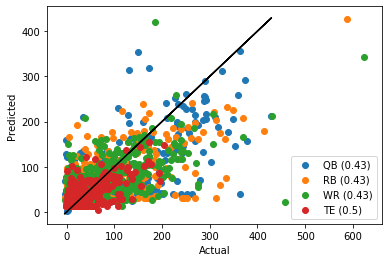

In [5]:
y_pred = {}
bestParams = {}
coefs = {}
for pos in positions:
    params = {
    'alpha':[10**x for x in range(-4,6)],
}

    grid = GridSearchCV(
        linear_model.Lasso(),
        params,
        n_jobs = -1,
        verbose = 7,
        cv = 5
    ).fit(X_train[pos],y_train[pos])

    bestParams[pos] = grid.best_params_

    m = linear_model.Lasso(**grid.best_params_)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    coefs[pos] = pd.DataFrame([X_train[pos].columns,m.coef_]).transpose()

    
for pos in positions:
    display(coefs[pos].reindex(coefs[pos][1].abs().sort_values(ascending=False).index).set_index(0).transpose())
    
for pos in positions:
    print(f'{pos}: {bestParams[pos]}')
printStats(y_dev,y_pred)

#### Automatic CV

,fanPts-1,pass_touchdown-2_seasonTotal,touchdown-1_seasonTotal,pass_touchdown-1_seasonTotal,air_yards-3_seasonTotal,sack-2_avgPerGame,sack-3_avgPerGame,tackled_for_loss-3_avgPerGame,air_yards-1_seasonTotal,yards_gained-1_avgPerGame,qb_scramble-2_avgPerGame,tackled_for_loss-2_seasonTotal,pass_attempt-3_seasonTotal,complete_pass-3_seasonTotal,air_yards-2_seasonTotal,fumble-3_seasonTotal,pass_touchdown-3_seasonTotal,qb_dropback-3_seasonTotal,yards_gained-3_seasonTotal,tackled_for_loss-3_seasonTotal,sack-2_seasonTotal,qb_scramble-2_seasonTotal,qb_hit-2_seasonTotal,qb_dropback-2_seasonTotal,touchdown-3_seasonTotal,fumble-2_seasonTotal,pass_attempt-2_seasonTotal,complete_pass-2_seasonTotal,touchdown-2_seasonTotal,qb_scramble-3_seasonTotal,yards_gained-2_seasonTotal,sack-1_seasonTotal,qb_scramble-1_seasonTotal,qb_hit-1_seasonTotal,qb_dropback-1_seasonTotal,pass_attempt-1_seasonTotal,complete_pass-1_seasonTotal,fumble-1_seasonTotal,yards_gained-1_seasonTotal,qb_hit-3_seasonTotal,fanPts-3,sack-3_seasonTotal,touchdown-3_avgPerGame,pass_touchdown-2_avgPerGame,air_yards-2_avgPerGame,qb_dropback-2_avgPerGame,qb_hit-2_avgPerGame,yards_gained-3_avgPerGame,fumble-3_avgPerGame,complete_pass-3_avgPerGame,tackled_for_loss-1_avgPerGame,pass_attempt-3_avgPerGame,pass_touchdown-3_avgPerGame,air_yards-3_avgPerGame,qb_dropback-3_avgPerGame,qb_hit-3_avgPerGame,qb_scramble-3_avgPerGame,pass_attempt-2_avgPerGame,complete_pass-2_avgPerGame,touchdown-2_avgPerGame,fumble-2_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,sack-1_avgPerGame,qb_scramble-1_avgPerGame,qb_hit-1_avgPerGame,qb_dropback-1_avgPerGame,air_yards-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_attempt-1_avgPerGame,complete_pass-1_avgPerGame,touchdown-1_avgPerGame,fumble-1_avgPerGame,fanPts-2,tackled_for_loss-1_seasonTotal
1,30.570,24.285,12.285,10.729,6.470,-4.713,-3.882,-3.465,1.177,0.490,-0.336,-0.159,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000


,yards_gained-1_seasonTotal,fanPts-1,fanPts-2,fanPts-3,tackled_for_loss-1_seasonTotal,rush_touchdown-1_seasonTotal,fumble-1_seasonTotal,touchdown-1_seasonTotal,rush_attempt-2_seasonTotal,rush_touchdown-2_seasonTotal,touchdown-3_seasonTotal,yards_gained-2_seasonTotal,fumble-2_seasonTotal,touchdown-2_seasonTotal,rush_attempt-3_seasonTotal,rush_touchdown-3_seasonTotal,tackled_for_loss-3_seasonTotal,yards_gained-3_seasonTotal,fumble-3_seasonTotal,tackled_for_loss-2_seasonTotal,rush_touchdown-1_avgPerGame,rush_attempt-1_avgPerGame,tackled_for_loss-1_avgPerGame,touchdown-3_avgPerGame,fumble-3_avgPerGame,yards_gained-3_avgPerGame,tackled_for_loss-3_avgPerGame,rush_touchdown-3_avgPerGame,rush_attempt-3_avgPerGame,touchdown-2_avgPerGame,fumble-2_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,rush_touchdown-2_avgPerGame,rush_attempt-2_avgPerGame,touchdown-1_avgPerGame,fumble-1_avgPerGame,yards_gained-1_avgPerGame,rush_attempt-1_seasonTotal
1,23.446,20.223,5.375,1.027,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000


,fanPts-1,yards_gained-1_seasonTotal,pass_touchdown-2_seasonTotal,yards_gained-2_seasonTotal,air_yards-3_avgPerGame,yards_after_catch-2_seasonTotal,fumble-2_seasonTotal,tackled_for_loss-1_seasonTotal,pass_attempt-1_seasonTotal,air_yards-2_seasonTotal,pass_touchdown-3_seasonTotal,pass_attempt-3_seasonTotal,complete_pass-3_seasonTotal,touchdown-3_seasonTotal,fumble-3_seasonTotal,yards_gained-3_seasonTotal,tackled_for_loss-3_seasonTotal,fumble-1_seasonTotal,touchdown-1_seasonTotal,pass_touchdown-1_seasonTotal,pass_attempt-2_seasonTotal,complete_pass-2_seasonTotal,touchdown-2_seasonTotal,yards_after_catch-3_seasonTotal,complete_pass-1_seasonTotal,tackled_for_loss-2_seasonTotal,yards_after_catch-1_seasonTotal,air_yards-1_seasonTotal,air_yards-3_seasonTotal,fanPts-3,tackled_for_loss-1_avgPerGame,pass_attempt-2_avgPerGame,yards_after_catch-3_avgPerGame,pass_touchdown-3_avgPerGame,pass_attempt-3_avgPerGame,complete_pass-3_avgPerGame,touchdown-3_avgPerGame,fumble-3_avgPerGame,yards_gained-3_avgPerGame,tackled_for_loss-3_avgPerGame,yards_after_catch-2_avgPerGame,air_yards-2_avgPerGame,pass_touchdown-2_avgPerGame,complete_pass-2_avgPerGame,fanPts-2,touchdown-2_avgPerGame,fumble-2_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,yards_after_catch-1_avgPerGame,air_yards-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_attempt-1_avgPerGame,complete_pass-1_avgPerGame,touchdown-1_avgPerGame,fumble-1_avgPerGame,yards_gained-1_avgPerGame
1,19.375,18.484,4.347,3.810,-3.125,1.635,1.449,1.104,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000


,yards_gained-1_seasonTotal,yards_gained-1_avgPerGame,fanPts-3,complete_pass-3_avgPerGame,yards_gained-2_seasonTotal,fumble-1_seasonTotal,pass_touchdown-1_seasonTotal,tackled_for_loss-1_avgPerGame,pass_attempt-3_avgPerGame,tackled_for_loss-2_seasonTotal,air_yards-1_avgPerGame,fumble-2_avgPerGame,pass_touchdown-3_seasonTotal,complete_pass-2_seasonTotal,tackled_for_loss-2_avgPerGame,air_yards-3_seasonTotal,fumble-3_seasonTotal,pass_attempt-2_seasonTotal,tackled_for_loss-3_seasonTotal,yards_after_catch-2_seasonTotal,air_yards-2_seasonTotal,pass_touchdown-2_seasonTotal,yards_gained-3_seasonTotal,yards_after_catch-3_avgPerGame,touchdown-2_seasonTotal,complete_pass-3_seasonTotal,fumble-2_seasonTotal,yards_after_catch-1_seasonTotal,air_yards-1_seasonTotal,pass_attempt-1_seasonTotal,complete_pass-1_seasonTotal,touchdown-1_seasonTotal,fanPts-1,touchdown-3_seasonTotal,yards_after_catch-3_seasonTotal,pass_attempt-3_seasonTotal,air_yards-3_avgPerGame,pass_touchdown-3_avgPerGame,touchdown-3_avgPerGame,fumble-3_avgPerGame,yards_gained-3_avgPerGame,tackled_for_loss-3_avgPerGame,yards_after_catch-2_avgPerGame,air_yards-2_avgPerGame,pass_touchdown-2_avgPerGame,pass_attempt-2_avgPerGame,complete_pass-2_avgPerGame,touchdown-2_avgPerGame,yards_gained-2_avgPerGame,yards_after_catch-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_attempt-1_avgPerGame,complete_pass-1_avgPerGame,touchdown-1_avgPerGame,fumble-1_avgPerGame,fanPts-2,tackled_for_loss-1_seasonTotal
1,20.756,4.736,4.285,-4.154,1.979,-1.808,1.808,1.608,-1.563,-1.462,1.418,-1.073,0.835,0.668,-0.222,0.159,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000


,MAE,RMSE,R^2
QB,61.900,81.500,0.440
RB,44.300,61.600,0.430
WR,37.800,54.900,0.430
TE,20.900,29.700,0.490


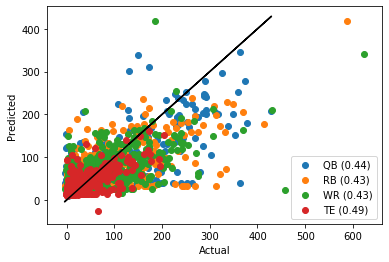

In [10]:
y_pred = {}
for pos in positions:
    m = linear_model.LassoCV(max_iter=5000)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    coefs = pd.DataFrame([X_train[pos].columns,m.coef_]).transpose()
    display(coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose())
    
printStats(y_dev, y_pred)

### Elastic Net Regression

#### Base model

,pass_touchdown-1_seasonTotal,touchdown-1_seasonTotal,fanPts-1,pass_touchdown-2_seasonTotal,yards_gained-1_seasonTotal,touchdown-2_seasonTotal,fanPts-2,pass_touchdown-1_avgPerGame,complete_pass-1_seasonTotal,sack-3_avgPerGame,sack-2_avgPerGame,qb_dropback-1_seasonTotal,pass_attempt-1_seasonTotal,air_yards-3_seasonTotal,air_yards-1_seasonTotal,touchdown-1_avgPerGame,yards_gained-1_avgPerGame,yards_gained-2_seasonTotal,tackled_for_loss-3_avgPerGame,pass_touchdown-2_avgPerGame,sack-1_avgPerGame,pass_touchdown-3_seasonTotal,complete_pass-2_seasonTotal,qb_hit-1_seasonTotal,fumble-2_avgPerGame,qb_hit-3_seasonTotal,complete_pass-3_seasonTotal,touchdown-3_avgPerGame,air_yards-2_seasonTotal,tackled_for_loss-2_seasonTotal,pass_attempt-3_avgPerGame,pass_attempt-2_avgPerGame,qb_scramble-2_avgPerGame,fanPts-3,touchdown-2_avgPerGame,qb_hit-2_avgPerGame,yards_gained-3_seasonTotal,touchdown-3_seasonTotal,qb_dropback-3_avgPerGame,qb_hit-3_avgPerGame,qb_dropback-2_avgPerGame,fumble-1_seasonTotal,qb_dropback-2_seasonTotal,tackled_for_loss-3_seasonTotal,qb_scramble-1_avgPerGame,qb_hit-2_seasonTotal,sack-3_seasonTotal,fumble-3_avgPerGame,qb_dropback-3_seasonTotal,fumble-1_avgPerGame,pass_attempt-2_seasonTotal,complete_pass-1_avgPerGame,yards_gained-3_avgPerGame,qb_scramble-2_seasonTotal,pass_attempt-3_seasonTotal,sack-2_seasonTotal,complete_pass-3_avgPerGame,sack-1_seasonTotal,complete_pass-2_avgPerGame,pass_attempt-1_avgPerGame,qb_scramble-3_avgPerGame,air_yards-1_avgPerGame,tackled_for_loss-1_avgPerGame,qb_scramble-3_seasonTotal,air_yards-3_avgPerGame,pass_touchdown-3_avgPerGame,qb_dropback-1_avgPerGame,air_yards-2_avgPerGame,yards_gained-2_avgPerGame,qb_scramble-1_seasonTotal,fumble-3_seasonTotal,qb_hit-1_avgPerGame,tackled_for_loss-2_avgPerGame,fumble-2_seasonTotal,tackled_for_loss-1_seasonTotal
1,7.959,7.894,7.303,6.256,5.803,5.406,4.547,4.505,4.170,-3.885,-3.855,3.811,3.519,3.418,3.241,3.095,3.077,2.896,-2.800,2.545,-2.515,2.209,1.855,1.792,-1.721,1.688,1.441,-1.326,1.280,-1.242,-1.220,-1.211,-1.174,1.172,1.074,-1.045,0.992,0.991,-0.957,-0.951,-0.843,0.792,0.679,-0.642,-0.639,0.534,-0.518,0.506,0.435,-0.409,0.404,0.397,-0.388,-0.355,0.214,-0.197,-0.172,0.090,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000


,yards_gained-1_seasonTotal,fanPts-1,touchdown-1_seasonTotal,yards_gained-1_avgPerGame,fumble-1_seasonTotal,yards_gained-2_seasonTotal,fanPts-2,touchdown-2_seasonTotal,yards_gained-3_seasonTotal,fanPts-3,tackled_for_loss-1_seasonTotal,rush_attempt-1_seasonTotal,tackled_for_loss-1_avgPerGame,touchdown-3_seasonTotal,rush_touchdown-1_seasonTotal,rush_attempt-3_avgPerGame,fumble-1_avgPerGame,rush_touchdown-3_avgPerGame,rush_attempt-1_avgPerGame,tackled_for_loss-3_avgPerGame,touchdown-1_avgPerGame,fumble-3_seasonTotal,tackled_for_loss-2_avgPerGame,yards_gained-2_avgPerGame,rush_touchdown-2_avgPerGame,fumble-2_seasonTotal,yards_gained-3_avgPerGame,rush_attempt-2_avgPerGame,rush_attempt-2_seasonTotal,touchdown-3_avgPerGame,fumble-3_avgPerGame,rush_touchdown-3_seasonTotal,rush_touchdown-2_seasonTotal,tackled_for_loss-2_seasonTotal,rush_attempt-3_seasonTotal,tackled_for_loss-3_seasonTotal,touchdown-2_avgPerGame,fumble-2_avgPerGame,rush_touchdown-1_avgPerGame
1,10.108,9.489,6.765,4.506,3.427,3.185,3.039,2.154,1.874,1.735,1.681,1.650,1.346,1.148,1.049,-1.039,-1.023,-0.894,0.678,-0.650,0.513,0.401,-0.389,0.298,-0.257,0.193,0.131,-0.127,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000


,yards_gained-1_seasonTotal,fanPts-1,complete_pass-1_seasonTotal,touchdown-1_seasonTotal,tackled_for_loss-1_seasonTotal,yards_gained-1_avgPerGame,pass_attempt-1_seasonTotal,pass_touchdown-1_seasonTotal,yards_gained-2_seasonTotal,fanPts-2,air_yards-3_avgPerGame,pass_touchdown-2_seasonTotal,touchdown-2_seasonTotal,yards_after_catch-1_seasonTotal,fumble-2_seasonTotal,air_yards-1_seasonTotal,touchdown-1_avgPerGame,yards_after_catch-2_seasonTotal,tackled_for_loss-2_seasonTotal,tackled_for_loss-1_avgPerGame,complete_pass-1_avgPerGame,air_yards-2_avgPerGame,complete_pass-2_seasonTotal,tackled_for_loss-3_avgPerGame,air_yards-3_seasonTotal,pass_touchdown-1_avgPerGame,fumble-1_avgPerGame,tackled_for_loss-3_seasonTotal,pass_touchdown-2_avgPerGame,tackled_for_loss-2_avgPerGame,pass_touchdown-3_seasonTotal,yards_after_catch-3_seasonTotal,fumble-3_seasonTotal,fumble-3_avgPerGame,pass_attempt-1_avgPerGame,yards_after_catch-2_avgPerGame,pass_attempt-2_seasonTotal,pass_attempt-3_avgPerGame,fumble-1_seasonTotal,touchdown-3_seasonTotal,touchdown-3_avgPerGame,yards_gained-2_avgPerGame,yards_gained-3_seasonTotal,complete_pass-2_avgPerGame,yards_after_catch-3_avgPerGame,pass_touchdown-3_avgPerGame,yards_gained-3_avgPerGame,pass_attempt-2_avgPerGame,fumble-2_avgPerGame,touchdown-2_avgPerGame,yards_after_catch-1_avgPerGame,air_yards-1_avgPerGame,complete_pass-3_avgPerGame,pass_attempt-3_seasonTotal,complete_pass-3_seasonTotal,air_yards-2_seasonTotal,fanPts-3
1,6.401,5.897,3.982,3.953,3.741,3.404,3.328,3.076,2.550,2.359,-2.156,2.127,1.750,1.724,1.471,1.278,1.272,1.263,1.018,0.972,0.906,-0.899,0.872,-0.768,-0.760,0.657,-0.566,0.483,0.479,-0.353,0.274,0.273,0.266,0.218,0.186,-0.178,0.160,-0.140,0.107,0.085,-0.073,0.030,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000


,yards_gained-1_seasonTotal,yards_gained-1_avgPerGame,fanPts-1,complete_pass-1_seasonTotal,pass_attempt-1_seasonTotal,touchdown-1_seasonTotal,pass_touchdown-1_seasonTotal,tackled_for_loss-1_avgPerGame,complete_pass-1_avgPerGame,yards_gained-2_seasonTotal,air_yards-1_avgPerGame,air_yards-1_seasonTotal,tackled_for_loss-1_seasonTotal,complete_pass-3_avgPerGame,pass_attempt-3_avgPerGame,yards_after_catch-1_seasonTotal,fumble-2_avgPerGame,fanPts-3,complete_pass-2_seasonTotal,pass_attempt-1_avgPerGame,pass_touchdown-3_seasonTotal,yards_gained-3_seasonTotal,touchdown-3_seasonTotal,pass_attempt-2_seasonTotal,yards_gained-2_avgPerGame,yards_after_catch-3_avgPerGame,fanPts-2,tackled_for_loss-2_seasonTotal,fumble-1_seasonTotal,yards_after_catch-1_avgPerGame,tackled_for_loss-2_avgPerGame,fumble-1_avgPerGame,air_yards-3_seasonTotal,touchdown-2_seasonTotal,fumble-2_seasonTotal,fumble-3_avgPerGame,pass_touchdown-1_avgPerGame,touchdown-2_avgPerGame,touchdown-3_avgPerGame,complete_pass-2_avgPerGame,pass_touchdown-3_avgPerGame,air_yards-3_avgPerGame,pass_attempt-2_avgPerGame,air_yards-2_seasonTotal,pass_touchdown-2_seasonTotal,yards_after_catch-2_avgPerGame,yards_after_catch-2_seasonTotal,tackled_for_loss-3_seasonTotal,fumble-3_seasonTotal,pass_touchdown-2_avgPerGame,complete_pass-3_seasonTotal,pass_attempt-3_seasonTotal,yards_after_catch-3_seasonTotal,yards_gained-3_avgPerGame,touchdown-1_avgPerGame,tackled_for_loss-3_avgPerGame,air_yards-2_avgPerGame
1,4.375,3.782,3.773,2.545,2.235,1.870,1.846,1.513,1.242,1.097,1.042,1.030,0.990,-0.978,-0.942,0.916,-0.824,0.727,0.721,0.676,0.670,0.660,0.634,0.579,0.572,-0.480,0.437,-0.343,-0.183,0.169,-0.158,-0.110,0.107,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000


,MAE,RMSE,R^2
QB,61.400,81.000,0.440
RB,44.800,62.000,0.420
WR,38.200,55.200,0.420
TE,21.500,30.000,0.480


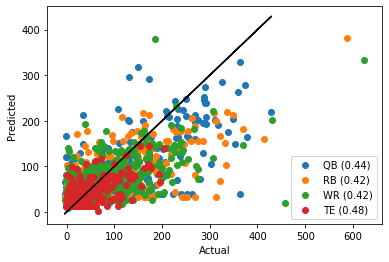

In [6]:
y_pred = {}
for pos in positions:
    m = linear_model.ElasticNet()
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    coefs = pd.DataFrame([X_train[pos].columns,m.coef_]).transpose()
    display(coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose())
    
printStats(y_dev, y_pred)

#### GridSearchCV

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 294 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 506 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:   18.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    7.8s finished


,pass_touchdown-2_seasonTotal,fanPts-1,touchdown-1_seasonTotal,sack-3_avgPerGame,air_yards-3_seasonTotal,sack-2_avgPerGame,pass_touchdown-1_seasonTotal,yards_gained-1_avgPerGame,tackled_for_loss-3_avgPerGame,fumble-3_avgPerGame,touchdown-3_avgPerGame,qb_scramble-2_avgPerGame,sack-1_avgPerGame,tackled_for_loss-2_seasonTotal,pass_touchdown-3_seasonTotal,qb_hit-3_seasonTotal,air_yards-1_seasonTotal,fumble-2_avgPerGame,pass_attempt-2_avgPerGame,qb_scramble-1_avgPerGame,pass_attempt-1_seasonTotal,qb_scramble-2_seasonTotal,sack-2_seasonTotal,tackled_for_loss-3_seasonTotal,fumble-3_seasonTotal,yards_gained-3_seasonTotal,qb_dropback-2_seasonTotal,touchdown-3_seasonTotal,complete_pass-3_seasonTotal,pass_attempt-3_seasonTotal,qb_hit-2_seasonTotal,complete_pass-2_seasonTotal,air_yards-2_seasonTotal,yards_gained-1_seasonTotal,pass_attempt-2_seasonTotal,complete_pass-1_seasonTotal,touchdown-2_seasonTotal,fumble-2_seasonTotal,sack-1_seasonTotal,qb_scramble-1_seasonTotal,qb_hit-1_seasonTotal,fumble-1_seasonTotal,qb_dropback-1_seasonTotal,yards_gained-2_seasonTotal,fanPts-3,qb_dropback-3_seasonTotal,qb_scramble-3_seasonTotal,qb_scramble-3_avgPerGame,qb_hit-3_avgPerGame,qb_dropback-3_avgPerGame,air_yards-3_avgPerGame,pass_touchdown-3_avgPerGame,pass_attempt-3_avgPerGame,complete_pass-3_avgPerGame,yards_gained-3_avgPerGame,qb_hit-2_avgPerGame,qb_dropback-2_avgPerGame,air_yards-2_avgPerGame,pass_touchdown-2_avgPerGame,complete_pass-2_avgPerGame,touchdown-2_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,qb_hit-1_avgPerGame,qb_dropback-1_avgPerGame,air_yards-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_attempt-1_avgPerGame,complete_pass-1_avgPerGame,touchdown-1_avgPerGame,fumble-1_avgPerGame,fanPts-2,tackled_for_loss-1_avgPerGame,sack-3_seasonTotal,tackled_for_loss-1_seasonTotal
1,27.727,25.419,20.292,-8.164,7.329,-6.698,6.205,5.017,-4.037,2.609,-2.271,-1.901,-1.691,-1.582,1.534,1.463,0.934,-0.877,-0.497,-0.063,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000


,yards_gained-1_seasonTotal,fanPts-1,fanPts-2,fanPts-3,fumble-1_avgPerGame,touchdown-2_seasonTotal,fumble-2_seasonTotal,yards_gained-3_seasonTotal,tackled_for_loss-3_seasonTotal,rush_touchdown-3_seasonTotal,rush_attempt-3_seasonTotal,tackled_for_loss-2_seasonTotal,yards_gained-2_seasonTotal,touchdown-3_seasonTotal,rush_touchdown-2_seasonTotal,rush_attempt-2_seasonTotal,touchdown-1_seasonTotal,fumble-1_seasonTotal,tackled_for_loss-1_seasonTotal,rush_touchdown-1_seasonTotal,fumble-3_seasonTotal,rush_touchdown-1_avgPerGame,rush_attempt-1_avgPerGame,touchdown-2_avgPerGame,touchdown-3_avgPerGame,fumble-3_avgPerGame,yards_gained-3_avgPerGame,tackled_for_loss-3_avgPerGame,rush_touchdown-3_avgPerGame,rush_attempt-3_avgPerGame,fumble-2_avgPerGame,tackled_for_loss-1_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,rush_touchdown-2_avgPerGame,rush_attempt-2_avgPerGame,touchdown-1_avgPerGame,yards_gained-1_avgPerGame,rush_attempt-1_seasonTotal
1,25.300,19.289,5.095,1.554,-0.786,0.610,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000


,fanPts-1,yards_gained-1_seasonTotal,pass_touchdown-2_seasonTotal,air_yards-3_avgPerGame,yards_gained-2_seasonTotal,yards_after_catch-2_seasonTotal,fumble-2_seasonTotal,tackled_for_loss-1_seasonTotal,tackled_for_loss-3_avgPerGame,fumble-1_avgPerGame,pass_attempt-1_seasonTotal,air_yards-2_seasonTotal,pass_attempt-3_seasonTotal,complete_pass-3_seasonTotal,touchdown-3_seasonTotal,fumble-3_seasonTotal,yards_gained-3_seasonTotal,tackled_for_loss-3_seasonTotal,fumble-1_seasonTotal,touchdown-1_seasonTotal,pass_touchdown-1_seasonTotal,pass_attempt-2_seasonTotal,complete_pass-2_seasonTotal,touchdown-2_seasonTotal,air_yards-3_seasonTotal,complete_pass-1_seasonTotal,tackled_for_loss-2_seasonTotal,yards_after_catch-1_seasonTotal,air_yards-1_seasonTotal,pass_touchdown-3_seasonTotal,fanPts-3,yards_after_catch-3_seasonTotal,tackled_for_loss-1_avgPerGame,yards_after_catch-3_avgPerGame,pass_touchdown-3_avgPerGame,pass_attempt-3_avgPerGame,complete_pass-3_avgPerGame,touchdown-3_avgPerGame,fumble-3_avgPerGame,yards_gained-3_avgPerGame,yards_after_catch-2_avgPerGame,air_yards-2_avgPerGame,pass_touchdown-2_avgPerGame,pass_attempt-2_avgPerGame,complete_pass-2_avgPerGame,touchdown-2_avgPerGame,fumble-2_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,yards_after_catch-1_avgPerGame,air_yards-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_attempt-1_avgPerGame,complete_pass-1_avgPerGame,touchdown-1_avgPerGame,fanPts-2,yards_gained-1_avgPerGame
1,19.448,18.534,4.656,-3.864,3.572,2.205,1.664,1.386,-0.268,-0.087,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000


,yards_gained-1_seasonTotal,yards_gained-1_avgPerGame,fanPts-1,pass_attempt-3_avgPerGame,complete_pass-3_avgPerGame,yards_gained-3_seasonTotal,air_yards-2_seasonTotal,pass_touchdown-1_seasonTotal,yards_gained-2_seasonTotal,tackled_for_loss-1_avgPerGame,touchdown-1_avgPerGame,air_yards-1_avgPerGame,fanPts-3,air_yards-3_avgPerGame,pass_attempt-1_avgPerGame,air_yards-2_avgPerGame,complete_pass-2_seasonTotal,complete_pass-1_seasonTotal,fumble-1_seasonTotal,fumble-2_avgPerGame,touchdown-2_seasonTotal,tackled_for_loss-2_seasonTotal,pass_touchdown-3_avgPerGame,tackled_for_loss-2_avgPerGame,yards_after_catch-3_avgPerGame,yards_after_catch-2_avgPerGame,yards_gained-3_avgPerGame,yards_after_catch-3_seasonTotal,tackled_for_loss-3_seasonTotal,yards_gained-2_avgPerGame,pass_attempt-2_seasonTotal,complete_pass-3_seasonTotal,yards_after_catch-1_avgPerGame,fumble-2_seasonTotal,fanPts-2,tackled_for_loss-3_avgPerGame,pass_attempt-3_seasonTotal,yards_after_catch-2_seasonTotal,pass_touchdown-1_avgPerGame,air_yards-3_seasonTotal,pass_touchdown-3_seasonTotal,fumble-3_avgPerGame,fumble-3_seasonTotal,fumble-1_avgPerGame,complete_pass-2_avgPerGame,tackled_for_loss-1_seasonTotal,pass_touchdown-2_avgPerGame,pass_touchdown-2_seasonTotal,touchdown-3_avgPerGame,yards_after_catch-1_seasonTotal,air_yards-1_seasonTotal,pass_attempt-1_seasonTotal,complete_pass-1_avgPerGame,touchdown-1_seasonTotal,touchdown-2_avgPerGame,pass_attempt-2_avgPerGame,touchdown-3_seasonTotal
1,9.773,8.677,6.689,-5.685,-4.993,4.082,-3.779,3.433,3.334,3.315,-3.044,3.036,2.812,2.632,-2.621,2.578,2.571,2.378,-2.094,-1.973,-1.951,-1.842,1.428,-1.191,-1.017,-0.884,-0.860,-0.703,0.678,0.624,0.615,0.609,-0.520,0.516,0.512,-0.473,0.465,-0.462,0.318,0.297,0.273,0.256,-0.183,0.148,0.069,0.050,-0.027,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000


QB: {'alpha': 1, 'l1_ratio': 1.0}
RB: {'alpha': 1, 'l1_ratio': 1.0}
WR: {'alpha': 1, 'l1_ratio': 1.0}
TE: {'alpha': 0.1, 'l1_ratio': 0.6}


,MAE,RMSE,R^2
QB,61.600,81.800,0.430
RB,44.200,61.600,0.430
WR,37.800,55.000,0.430
TE,20.800,30.200,0.480


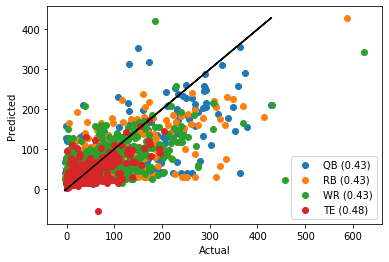

In [7]:
y_pred = {}
bestParams = {}
coefs = {}
for pos in positions:
    params = {
    'alpha':[10**x for x in range(-4,6)],
    'l1_ratio':[x/10 for x in range (0,11)]
}

    grid = GridSearchCV(
        linear_model.ElasticNet(),
        params,
        n_jobs = -1,
        verbose = 7,
        cv = 5
    ).fit(X_train[pos],y_train[pos])

    bestParams[pos] = grid.best_params_

    m = linear_model.ElasticNet(**grid.best_params_)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    coefs[pos] = pd.DataFrame([X_train[pos].columns,m.coef_]).transpose()

    
for pos in positions:
    display(coefs[pos].reindex(coefs[pos][1].abs().sort_values(ascending=False).index).set_index(0).transpose())
    
for pos in positions:
    print(f'{pos}: {bestParams[pos]}')
printStats(y_dev,y_pred)

#### Automatic CV

,fanPts-1,pass_touchdown-2_seasonTotal,touchdown-1_seasonTotal,pass_touchdown-1_seasonTotal,air_yards-3_seasonTotal,sack-2_avgPerGame,sack-3_avgPerGame,tackled_for_loss-3_avgPerGame,air_yards-1_seasonTotal,yards_gained-1_avgPerGame,qb_scramble-2_avgPerGame,tackled_for_loss-2_seasonTotal,pass_attempt-3_seasonTotal,complete_pass-3_seasonTotal,air_yards-2_seasonTotal,fumble-3_seasonTotal,pass_touchdown-3_seasonTotal,qb_dropback-3_seasonTotal,yards_gained-3_seasonTotal,tackled_for_loss-3_seasonTotal,sack-2_seasonTotal,qb_scramble-2_seasonTotal,qb_hit-2_seasonTotal,qb_dropback-2_seasonTotal,touchdown-3_seasonTotal,fumble-2_seasonTotal,pass_attempt-2_seasonTotal,complete_pass-2_seasonTotal,touchdown-2_seasonTotal,qb_scramble-3_seasonTotal,yards_gained-2_seasonTotal,sack-1_seasonTotal,qb_scramble-1_seasonTotal,qb_hit-1_seasonTotal,qb_dropback-1_seasonTotal,pass_attempt-1_seasonTotal,complete_pass-1_seasonTotal,fumble-1_seasonTotal,yards_gained-1_seasonTotal,qb_hit-3_seasonTotal,fanPts-3,sack-3_seasonTotal,touchdown-3_avgPerGame,pass_touchdown-2_avgPerGame,air_yards-2_avgPerGame,qb_dropback-2_avgPerGame,qb_hit-2_avgPerGame,yards_gained-3_avgPerGame,fumble-3_avgPerGame,complete_pass-3_avgPerGame,tackled_for_loss-1_avgPerGame,pass_attempt-3_avgPerGame,pass_touchdown-3_avgPerGame,air_yards-3_avgPerGame,qb_dropback-3_avgPerGame,qb_hit-3_avgPerGame,qb_scramble-3_avgPerGame,pass_attempt-2_avgPerGame,complete_pass-2_avgPerGame,touchdown-2_avgPerGame,fumble-2_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,sack-1_avgPerGame,qb_scramble-1_avgPerGame,qb_hit-1_avgPerGame,qb_dropback-1_avgPerGame,air_yards-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_attempt-1_avgPerGame,complete_pass-1_avgPerGame,touchdown-1_avgPerGame,fumble-1_avgPerGame,fanPts-2,tackled_for_loss-1_seasonTotal
1,30.570,24.285,12.285,10.729,6.470,-4.713,-3.882,-3.465,1.177,0.490,-0.336,-0.159,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000


,yards_gained-1_seasonTotal,fanPts-1,fanPts-2,fanPts-3,tackled_for_loss-1_seasonTotal,rush_touchdown-1_seasonTotal,fumble-1_seasonTotal,touchdown-1_seasonTotal,rush_attempt-2_seasonTotal,rush_touchdown-2_seasonTotal,touchdown-3_seasonTotal,yards_gained-2_seasonTotal,fumble-2_seasonTotal,touchdown-2_seasonTotal,rush_attempt-3_seasonTotal,rush_touchdown-3_seasonTotal,tackled_for_loss-3_seasonTotal,yards_gained-3_seasonTotal,fumble-3_seasonTotal,tackled_for_loss-2_seasonTotal,rush_touchdown-1_avgPerGame,rush_attempt-1_avgPerGame,tackled_for_loss-1_avgPerGame,touchdown-3_avgPerGame,fumble-3_avgPerGame,yards_gained-3_avgPerGame,tackled_for_loss-3_avgPerGame,rush_touchdown-3_avgPerGame,rush_attempt-3_avgPerGame,touchdown-2_avgPerGame,fumble-2_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,rush_touchdown-2_avgPerGame,rush_attempt-2_avgPerGame,touchdown-1_avgPerGame,fumble-1_avgPerGame,yards_gained-1_avgPerGame,rush_attempt-1_seasonTotal
1,23.446,20.223,5.375,1.027,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000


,fanPts-1,yards_gained-1_seasonTotal,pass_touchdown-2_seasonTotal,yards_gained-2_seasonTotal,air_yards-3_avgPerGame,yards_after_catch-2_seasonTotal,fumble-2_seasonTotal,tackled_for_loss-1_seasonTotal,pass_attempt-1_seasonTotal,air_yards-2_seasonTotal,pass_touchdown-3_seasonTotal,pass_attempt-3_seasonTotal,complete_pass-3_seasonTotal,touchdown-3_seasonTotal,fumble-3_seasonTotal,yards_gained-3_seasonTotal,tackled_for_loss-3_seasonTotal,fumble-1_seasonTotal,touchdown-1_seasonTotal,pass_touchdown-1_seasonTotal,pass_attempt-2_seasonTotal,complete_pass-2_seasonTotal,touchdown-2_seasonTotal,yards_after_catch-3_seasonTotal,complete_pass-1_seasonTotal,tackled_for_loss-2_seasonTotal,yards_after_catch-1_seasonTotal,air_yards-1_seasonTotal,air_yards-3_seasonTotal,fanPts-3,tackled_for_loss-1_avgPerGame,pass_attempt-2_avgPerGame,yards_after_catch-3_avgPerGame,pass_touchdown-3_avgPerGame,pass_attempt-3_avgPerGame,complete_pass-3_avgPerGame,touchdown-3_avgPerGame,fumble-3_avgPerGame,yards_gained-3_avgPerGame,tackled_for_loss-3_avgPerGame,yards_after_catch-2_avgPerGame,air_yards-2_avgPerGame,pass_touchdown-2_avgPerGame,complete_pass-2_avgPerGame,fanPts-2,touchdown-2_avgPerGame,fumble-2_avgPerGame,yards_gained-2_avgPerGame,tackled_for_loss-2_avgPerGame,yards_after_catch-1_avgPerGame,air_yards-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_attempt-1_avgPerGame,complete_pass-1_avgPerGame,touchdown-1_avgPerGame,fumble-1_avgPerGame,yards_gained-1_avgPerGame
1,19.375,18.484,4.347,3.810,-3.125,1.635,1.449,1.104,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000


,yards_gained-1_seasonTotal,yards_gained-1_avgPerGame,fanPts-3,complete_pass-3_avgPerGame,yards_gained-2_seasonTotal,fumble-1_seasonTotal,pass_touchdown-1_seasonTotal,tackled_for_loss-1_avgPerGame,pass_attempt-3_avgPerGame,tackled_for_loss-2_seasonTotal,air_yards-1_avgPerGame,fumble-2_avgPerGame,pass_touchdown-3_seasonTotal,complete_pass-2_seasonTotal,tackled_for_loss-2_avgPerGame,air_yards-3_seasonTotal,fumble-3_seasonTotal,pass_attempt-2_seasonTotal,tackled_for_loss-3_seasonTotal,yards_after_catch-2_seasonTotal,air_yards-2_seasonTotal,pass_touchdown-2_seasonTotal,yards_gained-3_seasonTotal,yards_after_catch-3_avgPerGame,touchdown-2_seasonTotal,complete_pass-3_seasonTotal,fumble-2_seasonTotal,yards_after_catch-1_seasonTotal,air_yards-1_seasonTotal,pass_attempt-1_seasonTotal,complete_pass-1_seasonTotal,touchdown-1_seasonTotal,fanPts-1,touchdown-3_seasonTotal,yards_after_catch-3_seasonTotal,pass_attempt-3_seasonTotal,air_yards-3_avgPerGame,pass_touchdown-3_avgPerGame,touchdown-3_avgPerGame,fumble-3_avgPerGame,yards_gained-3_avgPerGame,tackled_for_loss-3_avgPerGame,yards_after_catch-2_avgPerGame,air_yards-2_avgPerGame,pass_touchdown-2_avgPerGame,pass_attempt-2_avgPerGame,complete_pass-2_avgPerGame,touchdown-2_avgPerGame,yards_gained-2_avgPerGame,yards_after_catch-1_avgPerGame,pass_touchdown-1_avgPerGame,pass_attempt-1_avgPerGame,complete_pass-1_avgPerGame,touchdown-1_avgPerGame,fumble-1_avgPerGame,fanPts-2,tackled_for_loss-1_seasonTotal
1,20.756,4.736,4.285,-4.154,1.979,-1.808,1.808,1.608,-1.563,-1.462,1.418,-1.073,0.835,0.668,-0.222,0.159,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000


,MAE,RMSE,R^2
QB,61.900,81.500,0.440
RB,44.300,61.600,0.430
WR,37.800,54.900,0.430
TE,20.900,29.700,0.490


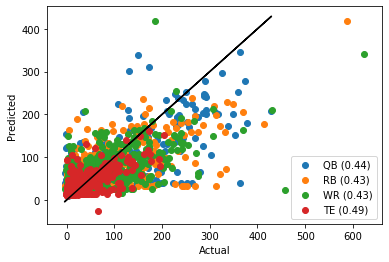

In [8]:
y_pred = {}
for pos in positions:
    m = linear_model.ElasticNetCV(l1_ratio=[x/10 for x in range (1,11)], max_iter=5000)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    coefs = pd.DataFrame([X_train[pos].columns,m.coef_]).transpose()
    display(coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose())
    
printStats(y_dev, y_pred)